In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import numpy as np


In [4]:
# Load the dataset
ds = load_dataset("carblacac/twitter-sentiment-analysis", trust_remote_code=True)

# Get the train and test splits
train_data = ds['train']
test_data = ds['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.44k [00:00<?, ?B/s]

twitter-sentiment-analysis.py:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/149985 [00:00<?, ? examples/s]

Map:   0%|          | 0/61998 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/120 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/62 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/119988 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29997 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/61998 [00:00<?, ? examples/s]

In [13]:
# Extract text reviews and labels (convert to list or numpy array)
X_train = train_data['text'][:50000]
y_train = np.array(train_data['feeling'][:50000])
X_test = test_data['text'][:10000]
y_test = np.array(test_data['feeling'][:10000])

In [14]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)  # Use 10,000 most common words
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of integers (tokens)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure they all have the same length (500 tokens)
X_train_padded = pad_sequences(X_train_sequences, maxlen=200)
X_test_padded = pad_sequences(X_test_sequences, maxlen=200)

In [15]:
# Define the model using the Functional API
input_layer = Input(shape=(200,))
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=200)(input_layer)

# Apply MultiHeadAttention
attention_output = MultiHeadAttention(num_heads=8, key_dim=128)(embedding_layer, embedding_layer)

# Pooling
pooled_output = GlobalAveragePooling1D()(attention_output)

# Dense output layer
output_layer = Dense(1, activation='sigmoid')(pooled_output)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
# Create the model
transformer_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
transformer_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [17]:

# Train the model
transformer_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.5042 - loss: 0.6937 - val_accuracy: 0.6321 - val_loss: 0.6535
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.7078 - loss: 0.5624 - val_accuracy: 0.7753 - val_loss: 0.4697
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8079 - loss: 0.4220 - val_accuracy: 0.7781 - val_loss: 0.4689
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8327 - loss: 0.3735 - val_accuracy: 0.7677 - val_loss: 0.5044
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8497 - loss: 0.3414 - val_accuracy: 0.7645 - val_loss: 0.5331


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


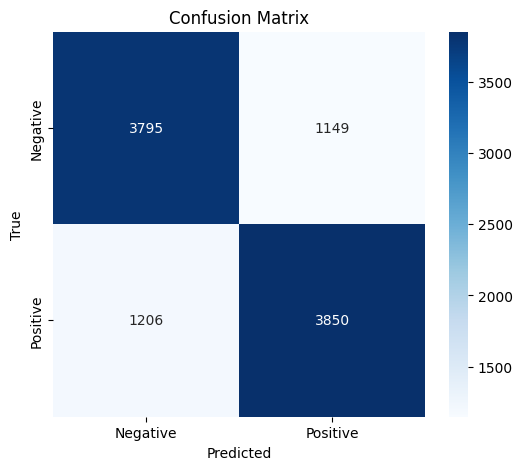

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test data
y_pred = (transformer_model.predict(X_test_padded) > 0.5).astype(int)  # Binary classification (0 or 1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
